# Challenge

In this module, we learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a house price dataset from Kaggle. In this challenge, you will keep working on this dataset.

_The Scenario_

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks:

_Challenge Steps_

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
7. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### Import Statements

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import neighbors
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings('ignore')

### 1. Loading the House Prices Dataframe

In [41]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

### 2. Exploratory Data Analysis

_Getting a Feel for the Dataframe_

In [42]:
print(house_prices_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

Because this dataframe has 81 columns, and most of the columns have more than 1,000 datapoints, I'm going to drop the five columns that have less than 800 datapoints. Those columns are: 'alley', 'fence', 'fireplacequ', 'poolqc' and 'miscfeature'.

I'm also going to drop 'id' because it's a numbered list of the properties.

In [43]:
fist_revision_house_prices_df = house_prices_df.drop(columns=['alley', 'fence', 'fireplacequ', 'poolqc', 'miscfeature', 'id'])

fist_revision_house_prices_df.shape

(1460, 75)

_Transforming Categorical Variables_

Because many of the columns' data types are objects, I'm going to look at the values in those columns and see if I can use one hot encoding to transform the data into ones and zeros.

If I can't transform a column, I'm going to drop it given how many variables there are.

In [44]:
fist_revision_house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1452 no

In [45]:
# This is the code I used to check the columns.

pd.Series(' '.join(fist_revision_house_prices_df['salecondition']).split()).value_counts()[:50]

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
dtype: int64

In [46]:
# I'm going to drop these columns because they can't be transformed with one-hot encoding and there are already many columns
# in the dataframe.

second_revision_house_prices_df = fist_revision_house_prices_df.drop(columns=['mszoning', 'lotshape', 'landcontour', 
                                    'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 
                                    'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 
                                    'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtexposure', 'bsmtfintype1', 
                                    'bsmtfintype2', 'heating', 'heatingqc', 'electrical', 'kitchenqual', 'functional', 
                                    'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'saletype', 
                                    'salecondition'])

After dropping the columns, I'd like to see how many columns are left.

In [47]:
second_revision_house_prices_df.shape

(1460, 41)

That shows there are 41 columns left (there are 81 in the original dataframe). 

With that in mind, I'm going to transform the values of the object columns that are left ('street', 'utilities', 'bsmtcond' and 'centralair') using one hot encoding.

In [48]:
second_revision_house_prices_df['street'] = pd.get_dummies(second_revision_house_prices_df['street'], drop_first=True)

second_revision_house_prices_df['utilities'] = pd.get_dummies(second_revision_house_prices_df['utilities'], drop_first=True)

second_revision_house_prices_df['bsmtcond'] = pd.get_dummies(second_revision_house_prices_df['bsmtcond'], drop_first=True)

second_revision_house_prices_df['centralair'] = pd.get_dummies(second_revision_house_prices_df['centralair'], drop_first=True)

_Dealing with Missing Values_

The dataframe has missing values, so I'll fill those in with the median, which is a measure of central tendency.

To get that started, I'll re-confirm which columns are missing information.

In [49]:
(second_revision_house_prices_df.isnull().sum()*100) / second_revision_house_prices_df.isnull().count()

mssubclass       0.000
lotfrontage     17.740
lotarea          0.000
street           0.000
utilities        0.000
overallqual      0.000
overallcond      0.000
yearbuilt        0.000
yearremodadd     0.000
masvnrarea       0.548
bsmtcond         0.000
bsmtfinsf1       0.000
bsmtfinsf2       0.000
bsmtunfsf        0.000
totalbsmtsf      0.000
centralair       0.000
firstflrsf       0.000
secondflrsf      0.000
lowqualfinsf     0.000
grlivarea        0.000
bsmtfullbath     0.000
bsmthalfbath     0.000
fullbath         0.000
halfbath         0.000
bedroomabvgr     0.000
kitchenabvgr     0.000
totrmsabvgrd     0.000
fireplaces       0.000
garageyrblt      5.548
garagecars       0.000
garagearea       0.000
wooddecksf       0.000
openporchsf      0.000
enclosedporch    0.000
threessnporch    0.000
screenporch      0.000
poolarea         0.000
miscval          0.000
mosold           0.000
yrsold           0.000
saleprice        0.000
dtype: float64

A few columns are missing information, so I'll fill in that information with averages.

In [50]:
third_revision_house_prices_df = second_revision_house_prices_df.copy()

replace_nans_with_means_list = ['lotfrontage', 'masvnrarea', 'garageyrblt']

for col in replace_nans_with_means_list:
        third_revision_house_prices_df.fillna(third_revision_house_prices_df[replace_nans_with_means_list
        ].median(), inplace=True)

_Outliers_

I'm assuming the data has outliers, but I'd like to check. Since there are 41 columns, I'll check eight of the columns (or about 20% of them) for outliers.

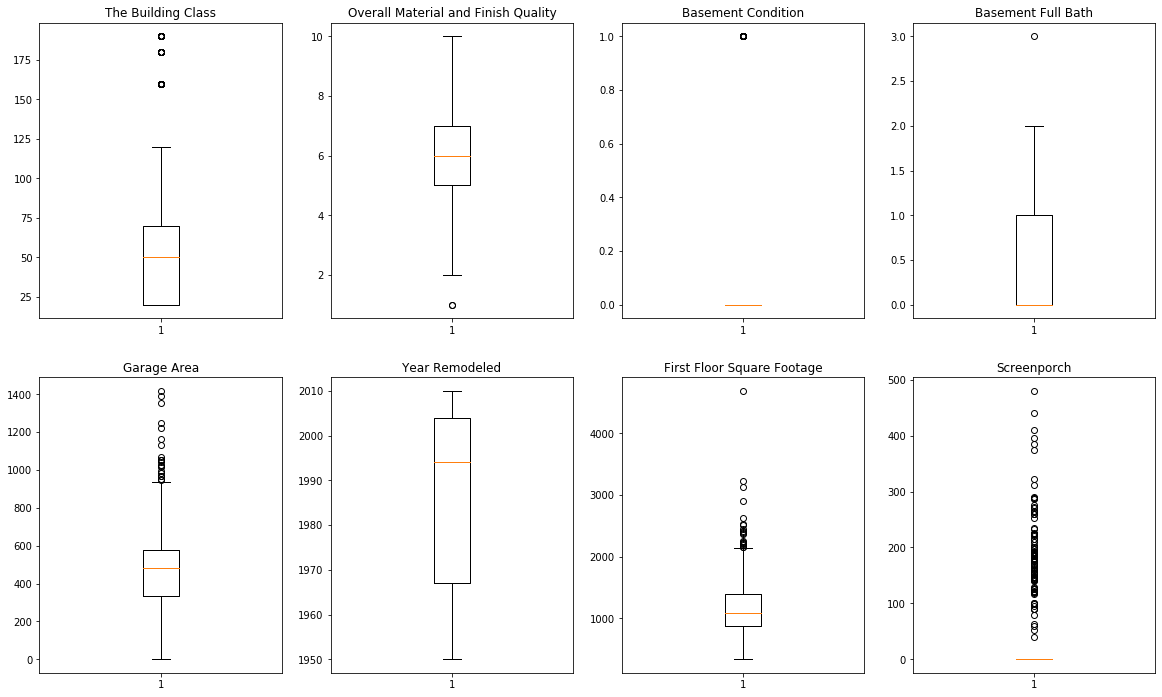

In [51]:
plt.figure(figsize=(20, 25))

plt.subplot(4, 4, 1)
plt.boxplot(third_revision_house_prices_df['mssubclass'], whis=1.5)
plt.title('The Building Class')

plt.subplot(4, 4, 2)
plt.boxplot(third_revision_house_prices_df['overallqual'], whis=1.5)
plt.title('Overall Material and Finish Quality')

plt.subplot(4, 4, 3)
plt.boxplot(third_revision_house_prices_df['bsmtcond'], whis=1.5)
plt.title('Basement Condition')

plt.subplot(4, 4, 4)
plt.boxplot(third_revision_house_prices_df['bsmtfullbath'], whis=1.5)
plt.title('Basement Full Bath')

plt.subplot(4, 4, 5)
plt.boxplot(third_revision_house_prices_df['garagearea'], whis=1.5)
plt.title('Garage Area')

plt.subplot(4, 4, 6)
plt.boxplot(third_revision_house_prices_df['yearremodadd'], whis=1.5)
plt.title('Year Remodeled')

plt.subplot(4, 4, 7)
plt.boxplot(third_revision_house_prices_df['firstflrsf'], whis=1.5)
plt.title('First Floor Square Footage')

plt.subplot(4, 4, 8)
plt.boxplot(third_revision_house_prices_df['screenporch'], whis=1.5)
plt.title('Screenporch')

plt.show()

The sample shows the outliers are skewed, so I'll transform the data to normalize it.

In [52]:
fourth_revision_house_prices_df = third_revision_house_prices_df.copy()

log_transform_list = ['mssubclass', 'lotfrontage', 'lotarea', 'street', 'utilities', 'overallqual', 'overallcond', 'yearbuilt',
                 'yearremodadd', 'masvnrarea', 'bsmtcond', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'centralair',
                 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
                 'halfbath', 'bedroomabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea',
                 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
                 'mosold', 'yrsold', 'saleprice']

for col in log_transform_list:
    np.log(fourth_revision_house_prices_df[log_transform_list])

_Exploring the Data_

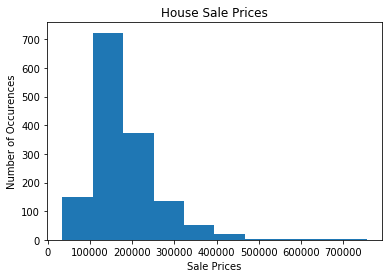

In [53]:
plt.hist(fourth_revision_house_prices_df['saleprice'])
plt.title('House Sale Prices')
plt.xlabel('Sale Prices')
plt.ylabel('Number of Occurences')

plt.show()

Even after being log transformed, the data's skewed to the left.

_Looking for Correlations in the Variables_

Text(0.5, 1, 'Correlation Matrix for the House Prices Data')

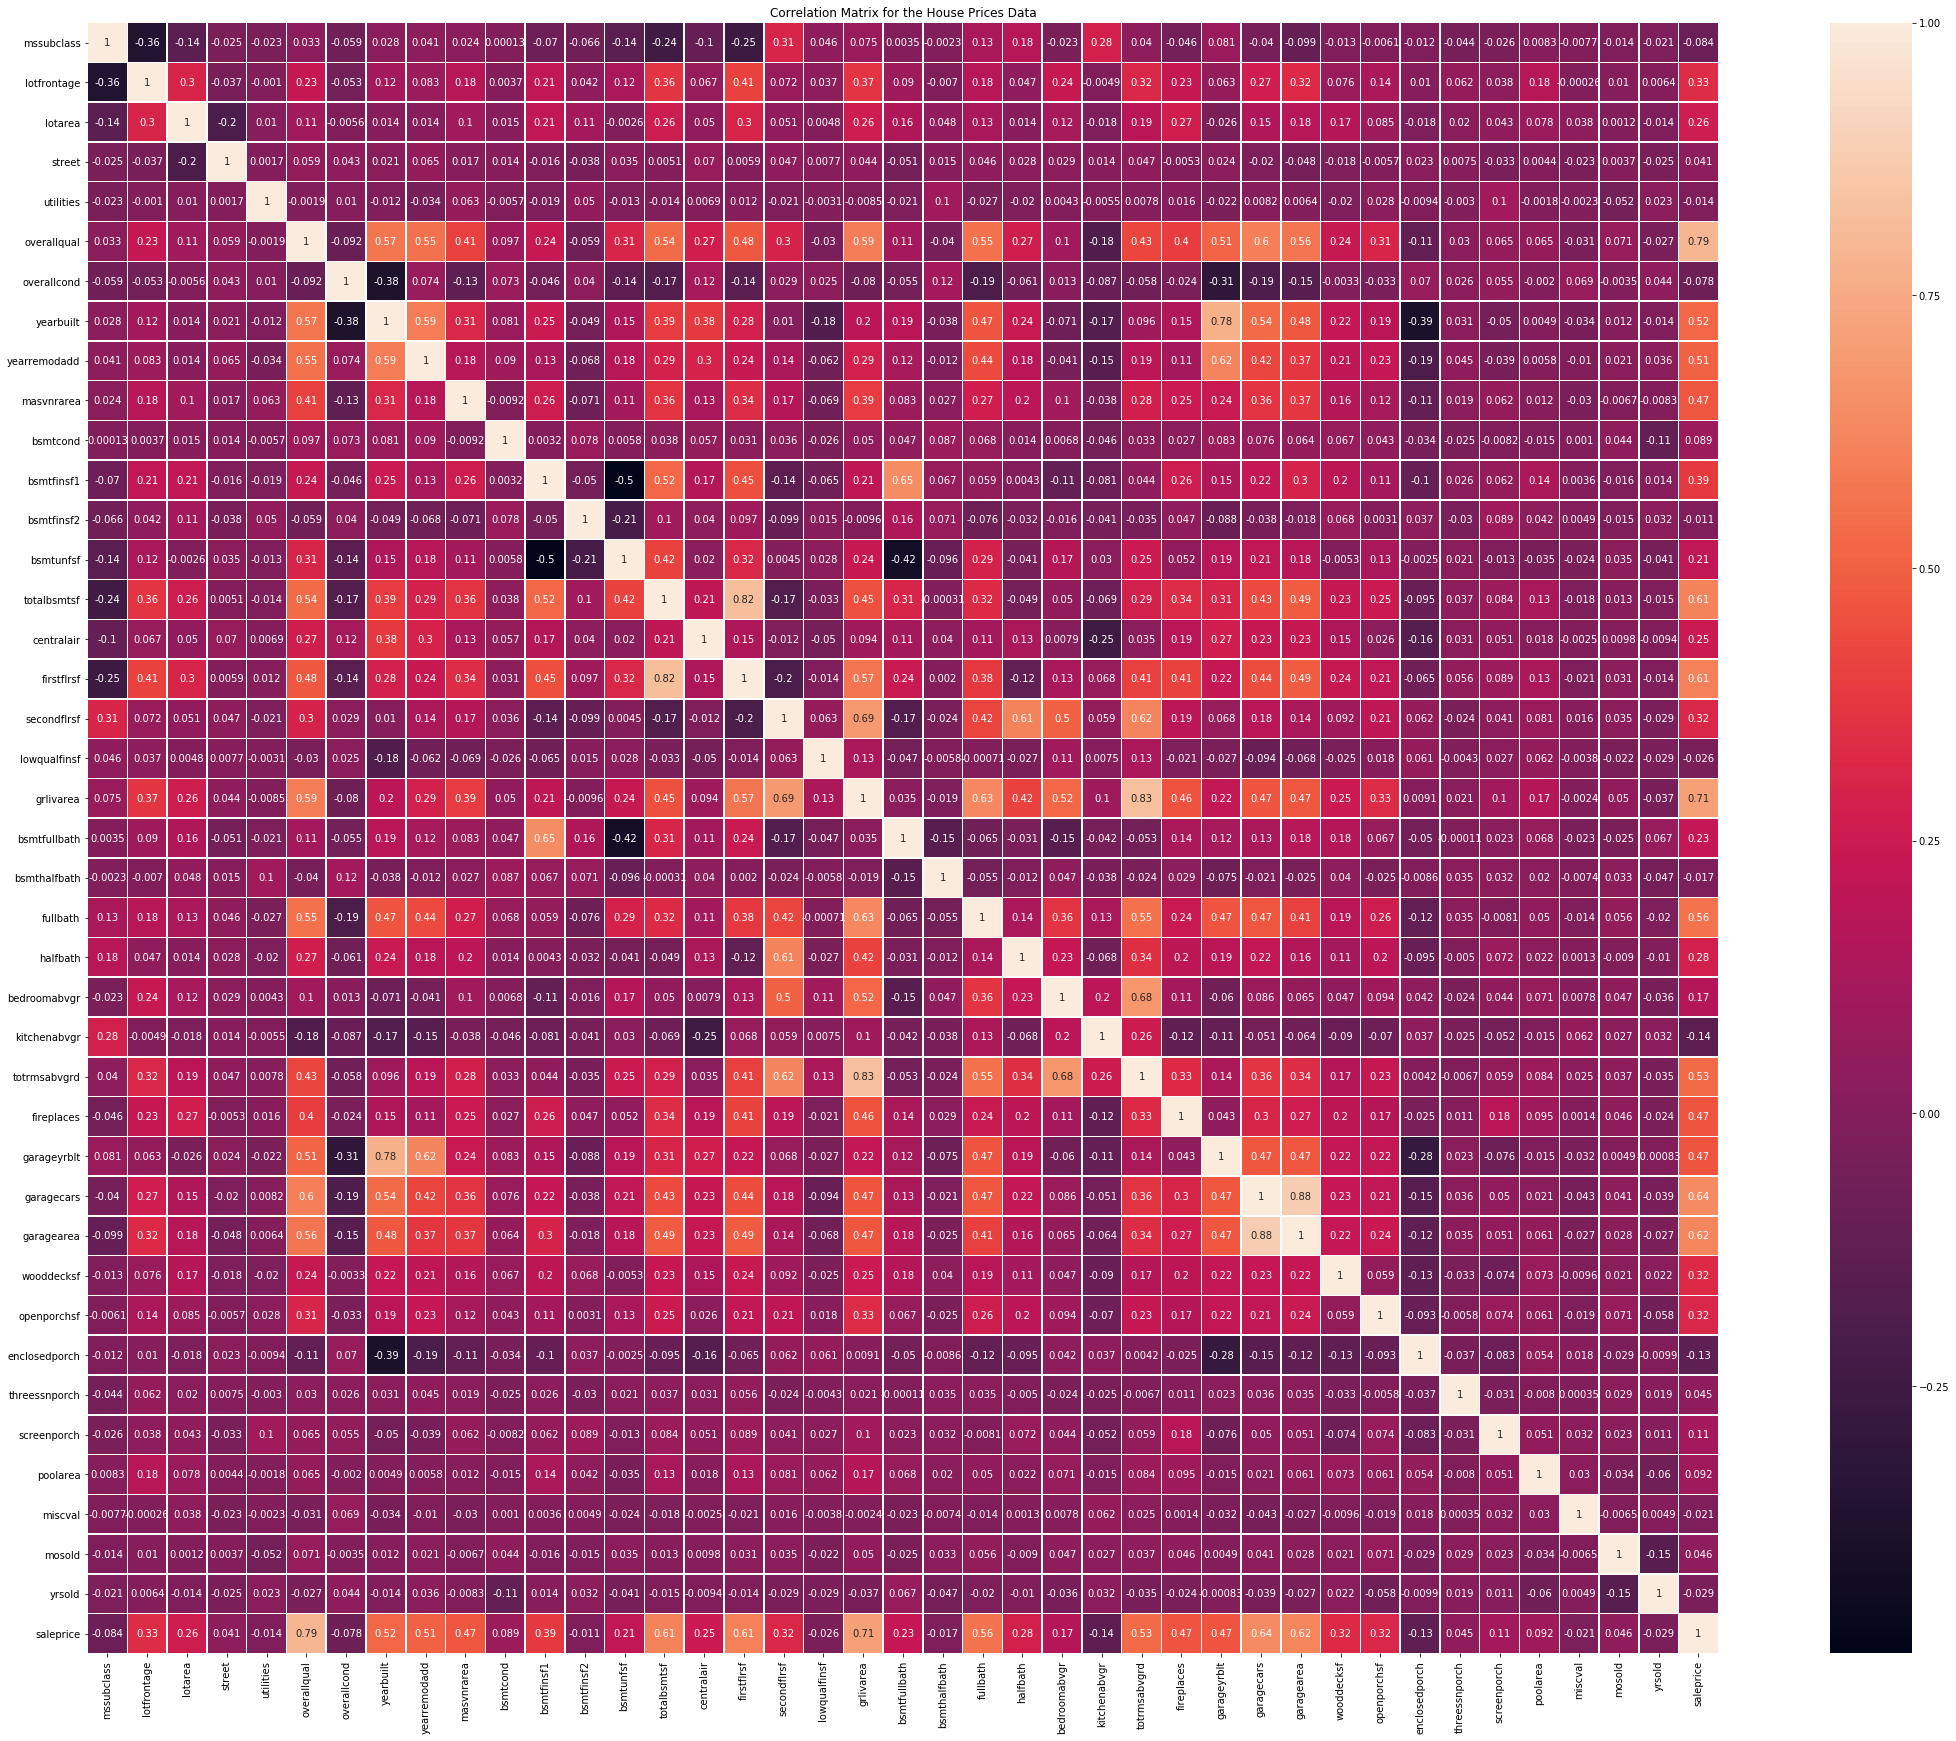

In [54]:
corrmat_fourth_revision_house_prices_df = fourth_revision_house_prices_df.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(corrmat_fourth_revision_house_prices_df, square=True, annot=True, linewidths=0.5)
plt.title('Correlation Matrix for the House Prices Data')

The correlation matrix is a bit hard to read, but the five columns with the highest correlation coefficient (CC) to 'saleprice' are: 

1. overallqual (0.79 CC)
2. grlivarea (0.71 CC)
3. garagecars (0.64 CC)
4. garagearea (0.62 CC)
5. totalbsmtsf (0.61 CC)

### 3. Splitting the Data into Train and Test Sets

20% of the data will be in the test set.

In [55]:
# Y is the target variable.
Y = fourth_revision_house_prices_df['saleprice']

# X is the feature set.
X = fourth_revision_house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('- The number of observations in the training set is: {}'.format(X_train.shape[0]))
print('- The number of observations in the test set is: {}'.format(X_test.shape[0]))

- The number of observations in the training set is: 1168
- The number of observations in the test set is: 292


### 4. Build Linear Regression Models, Train Them and Use K-Fold Cross Validation to Pick the Best Hyperparamters (If Your Model Includes One)

_OLS Regression_

In [56]:
# Fit an OLS model using sklearn.
lrm = LinearRegression()
results = lrm.fit(X_train, y_train)

# Make predictions here.
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(lrm.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(lrm.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.7589588843157826
--- Test Set Statistics ---
- R-squared of the model in test set is: 0.7656379370075236
- Mean absolute error of the prediction is: 25964.89937383187
- Mean squared error of the prediction is: 1573437538.2926502
- Root mean squared error of the prediction is: 39666.579614237606
- Mean absolute percentage error of the prediction is: 16.097178444700113


_LASSO Regression_

In [57]:
lasso_regr = Lasso(alpha=10**20.5)
lasso_regr.fit(X_train, y_train)

# Make predictions here.
y_preds_train = lasso_regr.predict(X_train)
y_preds_test = lasso_regr.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(lasso_regr.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(lasso_regr.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.0
--- Test Set Statistics ---
- R-squared of the model in test set is: -0.0016183407463286061
- Mean absolute error of the prediction is: 58023.64411709514
- Mean squared error of the prediction is: 6724569139.943377
- Root mean squared error of the prediction is: 82003.47029207592
- Mean absolute percentage error of the prediction is: 36.65964810134902


_Ridge Regression_

In [58]:
# Fitting a ridge regression model. Alpha's the regularization parameter (usually called Lambda). As alpah gets larger,
# parameter shrinkage gets more pronounced.

ridge_regr = Ridge(alpha=10**37)
ridge_regr.fit(X_train, y_train)

# We're making predictions here.
y_preds_train = ridge_regr.predict(X_train)
y_preds_test = ridge_regr.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(ridge_regr.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(ridge_regr.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.0
--- Test Set Statistics ---
- R-squared of the model in test set is: -0.0016183407463286061
- Mean absolute error of the prediction is: 58023.64411709514
- Mean squared error of the prediction is: 6724569139.943377
- Root mean squared error of the prediction is: 82003.47029207592
- Mean absolute percentage error of the prediction is: 36.65964810134902


_ElasticNet Regression_

In [59]:
elastic_regr = ElasticNet(alpha=10**21, l1_ratio=0.5)
elastic_regr.fit(X_train, y_train)

# We're making predictions here.
y_preds_train = elastic_regr.predict(X_train)
y_preds_test = elastic_regr.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(elastic_regr.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(elastic_regr.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.0
--- Test Set Statistics ---
- R-squared of the model in test set is: -0.0016183407463286061
- Mean absolute error of the prediction is: 58023.64411709514
- Mean squared error of the prediction is: 6724569139.943377
- Root mean squared error of the prediction is: 82003.47029207592
- Mean absolute percentage error of the prediction is: 36.65964810134902


_Comparing the Models' Performance_

In [60]:
regression_analysis_df = pd.read_excel('Regression Analysis for 19.8.xlsx', delimiter='\t')

regression_analysis_df.head()

,Metric,OLS Regression,LASSO Regression,Ridge Regression,ElasticNet Regression
0,R-Squared of the Model in Training Set,0.759,0.000,0.000,0.000
1,R-Squared of the Model in Test Set,0.766,-0.002,-0.002,-0.002
2,Mean Absolute Error of the Prediction,25964.899,58023.644,58023.644,58023.644
3,Mean Squared Error of the Prediction,1573437538.293,6724569139.943,6724569139.943,6724569139.943
4,Root Mean Squared Error of the Prediction,39666.580,82003.470,82003.470,82003.470


The OLS regression model performed the best because it had the smallest values across all the metrics.

### 5. Evaluate Your Best Model on the Test Set

In [61]:
# Fit an OLS model using sklearn.
lrm = LinearRegression()
results = lrm.fit(X_train, y_train)

# Make predictions here.
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(lrm.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(lrm.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.7589588843157826
--- Test Set Statistics ---
- R-squared of the model in test set is: 0.7656379370075236
- Mean absolute error of the prediction is: 25964.89937383187
- Mean squared error of the prediction is: 1573437538.2926502
- Root mean squared error of the prediction is: 39666.579614237606
- Mean absolute percentage error of the prediction is: 16.097178444700113


_Observations_ 

The performance statistics of the OLS model are lower than the LASSO, Ridge and ElasticNet models. Overall, this model had the best performance on the test set than the other three models did.

While this model could be improved on, it performs reasonably well.

### 6. Add Variables

Further details on this step: so far, you've only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. 

Try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

_Adding an "Interest Rate" Variable_

Because interest rates impact housing markets, I'll add a column for the average interest on a 30-year fixed mortgage for all the years houses were sold in the house prices dataframe.

To do that, I'll need to find out what years are included in the dataframe.

In [62]:
fourth_revision_house_prices_df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

From the information above, I can see that information from 2006 to 2010 is included in the dataframe.

The Federal Reserve Bank of St. Louis published data on [30-year fixed rate mortgages in the United States](https://fred.stlouisfed.org/graph/?g=NUh), so I used that to get the average interest rates for 2006 through 2010:

- 2006: 6.41%
- 2007: 6.34%
- 2008: 6.03%
- 2009: 5.04%
- 2010: 4.96%

Next I'll add a column for interest rates (please note I'll use the 'yrsold' column to make the 'interestrate' column).

In [63]:
fifth_revision_house_prices_df = fourth_revision_house_prices_df.copy()

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['yrsold']

In [64]:
# In the 'interestrate' column, I'll replace all the years with their average 30-year mortgage interest rate.

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['interestrate'].replace(2006, 0.0641)

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['interestrate'].replace(2007, 0.0634)

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['interestrate'].replace(2008, 0.0603)

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['interestrate'].replace(2009, 0.0504)

fifth_revision_house_prices_df['interestrate'] = fifth_revision_house_prices_df['interestrate'].replace(2010, 0.0496)

In [65]:
fifth_revision_house_prices_df[['yrsold', 'interestrate']].head()

,yrsold,interestrate
0,2008,0.060
1,2007,0.063
2,2008,0.060
3,2006,0.064
4,2008,0.060


_Creating a New Training and Test Set_

In [77]:
# Y is the target variable.
Y = fifth_revision_house_prices_df['saleprice']

# X is the feature set.
X = fifth_revision_house_prices_df[['interestrate', 'overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('- The number of observations in the training set is: {}'.format(X_train.shape[0]))
print('- The number of observations in the test set is: {}'.format(X_test.shape[0]))

- The number of observations in the training set is: 1168
- The number of observations in the test set is: 292


_Evaluating the Model on the Updated House Prices Dataframe_

In [78]:
# Fit an OLS model using sklearn.
lrm = LinearRegression()
results = lrm.fit(X_train, y_train)

# Make predictions here.
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print('- R-squared of the model in training set is: {}'.format(lrm.score(X_train, y_train)))
print('--- Test Set Statistics ---')
print('- R-squared of the model in test set is: {}'.format(lrm.score(X_test, y_test)))
print('- Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds_test)))
print('- Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds_test)))
print('- Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds_test)))
print('- Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds_test)
        / y_test)) * 100))

- R-squared of the model in training set is: 0.7590170997561674
--- Test Set Statistics ---
- R-squared of the model in test set is: 0.765279640792656
- Mean absolute error of the prediction is: 26002.820345355005
- Mean squared error of the prediction is: 1575843033.0519238
- Root mean squared error of the prediction is: 39696.889463179905
- Mean absolute percentage error of the prediction is: 16.116891878543512


_Comparing the First and Second OLS Regression Models_

In [79]:
second_regression_analysis_df = pd.read_excel('Second Regression Analysis for 19.8.xlsx', delimiter='\t')

second_regression_analysis_df.head()

,Metric,OLS Regression Model One,OLS Regression Model Two
0,R-Squared of the Model in Training Set,0.759,0.759
1,R-Squared of the Model in Test Set,0.766,0.765
2,Mean Absolute Error of the Prediction,25964.899,26002.820
3,Mean Squared Error of the Prediction,1573437538.293,1575843033.052
4,Root Mean Squared Error of the Prediction,39666.580,39696.889


I expected the second model to to better than the first, but surprisingly, the second model performed a bit worse than the first model.

And in this case, adding a variable to the model and the dataframe didn't improve on the model's performance.

### Appendix

I used the criterion below to look at each models' test set statistics and decide which one performed the best: 

- Mean Absolute Error: the average of the absolute values of the errors between the true values and the predicted values.
- Mean Squared Error: the average of the squared errors between the true values and the predicted values.
- Root Mean Squared Error: the square root of the MSE.
- Mean Absolute Percentage Error: the average of the ratio of the absolute values of the errors to the true values.

Here are some important points to note about those metrics:

- Lower values are desirable for all four metrics. The lower the value, the better the performance of the model.
- MAE, MSE, and RMSE are in the unit of the target variable but MAPE is unitless. So MAE, MSE, and RMSE are only useful if we compare different models that have the same target variable.
- MSE and RMSE penalize large errors more than the MAE and MAPE do. This means that MSE and RMSE are more useful when high error values are undesirable.
- For target values very close to zero, MAPE may provide a problematic picture of the performance as the ratio may go to very high values, and this may distort the average. It can also give division by zero errors if some values of the target are zero!